Progetto Data Mining A.A. 2019/2020
=====

Asteroidi e comete: analisi del diametro, dell'orbita e della pericolosità
---

Francesco Pasceri matricola 204963

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import dataframe_image as dfi

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [28]:
# size label grafici
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

Fase 4: Classificazione delle orbite
---

<b><u>
La terza fase del progetto è mirata alla classificazione. In particolare, dati i record, sottoposti già a pre processamento, vogliamo provare ad effettuare una classificazione delle orbite dei diversi corpi. Riportiamo sotto una leggenda delle diverse classi orbitali a cui faremo riferimento.
</u></b>

##### <u>Classi orbitali nel dataset:</u>

- 0 MBA -> Main Belt Asteroid : Asteroids with orbital elements;

- 1 OMB -> Outer Main Belt : Asteroids with orbital elements;

- 2 MCA -> Mars Crossing Asteroid : Asteroids that cross the orbit of Mars;

- 3 AMO -> Amor : Near-Earth asteroid orbits similar to that of 1221 Amor;

- 4 IMB -> Inner Main Belt : Asteroids with orbital elements;

- 5 TJN -> Jupiter Trojan : Asteroids trapped in Jupiter's L4/L5 Lagrange points;

- 6 CEN -> Centaur : Objects with orbits between Jupiter and Neptune;

- 7 APO -> Apollo : Near-Earth asteroid orbits which cross the Earth's orbit similar to that of 1862 Apollo;

- 8 ATE -> Atene : Near-Earth asteroid orbits similar to that of 2062 Aten;

- 9 AST -> Asteroid : Asteroid orbit not matching any defined orbit class;

- 10 TNO -> TransNeptunian Object : Objects with orbits outside Neptune;

- 11 ETc -> Encke-type Comet : Encke-type comet;

- 12 COM -> Comete : Comet orbit not matching any defined orbit class;

In [2]:
def compute_metrics(model, name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    scores = cross_validate(estimator=model, X=X_train, y=y_train, cv=5, 
                            n_jobs=-1, scoring=['accuracy','precision_macro','recall_macro','f1_macro'],
                           return_train_score=True)
    
    y_pred = model.predict(X_test)
    
    df = pd.DataFrame( confusion_matrix(y_true=y_test, y_pred=y_pred) )
    
    clf = {}
    clf['1_name'] = name
    clf['2_model'] = model
    clf['3_accuracy_train'] = np.mean(scores['train_accuracy'])
    clf['4_precision_train'] = np.mean(scores['train_precision_macro'])
    clf['5_recall_train'] = np.mean(scores['train_recall_macro'])
    clf['6_F1_train'] = np.mean(scores['train_f1_macro'])
    clf['3_accuracy_test'] = accuracy_score(y_pred=y_pred, y_true=y_test)
    clf['4_precision_test'] = precision_score(y_pred=y_pred, y_true = y_test, average='macro')
    clf['5_recall_test'] = recall_score(y_pred=y_pred, y_true = y_test, average='macro')
    clf['6_F1_test'] = f1_score(y_pred=y_pred, y_true = y_test, average='macro')

    dfi.export(df,'CLF_result/'+str(name)+".png")
    with open('Saved_files_classification/'+str(name),'wb') as f:
        pickle.dump(model,f)
    
    return clf

## 1. Import dati

In [3]:
with open('data','rb') as f:
    data = pickle.load(f)
    
data.head()

,neo,pha,H,diameter,albedo,e,a,q,i,om,...,class,condition_code,log(albedo),log(n),log(H),log(ad),log(e),log(om),log(i),log(q)
0,0,0,3.40,939.400,0.0900,0.076009,2.769165,2.558684,10.594067,80.305531,...,0,0,-2.407946,-1.542316,1.223775,1.091805,-2.576903,4.385838,2.360294,0.939493
1,0,0,4.20,545.000,0.1010,0.229972,2.773841,2.135935,34.832932,173.024741,...,0,0,-2.292635,-1.544847,1.435085,1.227225,-1.469797,5.153435,3.550563,0.758904
2,0,0,5.33,246.596,0.2140,0.256936,2.668285,1.982706,12.991043,169.851482,...,0,0,-1.541779,-1.486651,1.673351,1.210113,-1.358927,5.134924,2.564260,0.684462
3,0,0,3.00,525.400,0.4228,0.088721,2.361418,2.151909,7.141771,103.810804,...,0,0,-0.860856,-1.303390,1.098612,0.944266,-2.422253,4.642570,1.965961,0.766356
4,0,0,6.90,106.699,0.2740,0.190913,2.574037,2.082619,5.367427,141.571026,...,0,0,-1.294627,-1.432710,1.931521,1.120196,-1.655936,4.952802,1.680349,0.733626


In [4]:
data['class'].value_counts()

0     127090
1       7608
5       1876
7        740
2        612
4        555
3        337
8        125
6         52
10        12
9          7
Name: class, dtype: int64

## 2. Sampling per bilanciare il dataset, preparazione training e test set

In [5]:
ds_0 = data[data['class'] == 0].sample(600)
ds_1 = data[data['class'] == 1].sample(600)
ds_2 = data[data['class'] == 2].sample(600)
ds_3 = data[data['class'] == 3]
ds_4 = data[data['class'] == 4]
ds_5 = data[data['class'] == 5].sample(600)
ds_6 = data[data['class'] == 6]
ds_7 = data[data['class'] == 7].sample(600)
ds_8 = data[data['class'] == 8]
ds_9 = data[data['class'] == 9]
ds_10 = data[data['class'] == 10]

# merge 6, 9, 10 all together
ds_9['class'].replace({9 : 6},  inplace=True)
ds_10['class'].replace({10 : 6}, inplace=True)

ds = pd.concat([ds_0,ds_1,ds_2,ds_3,ds_4,ds_5,ds_6,ds_7,ds_8,ds_9,ds_10])
ds['class'].value_counts()

7    600
5    600
1    600
2    600
0    600
4    555
3    337
8    125
6     71
Name: class, dtype: int64

##### Normalizzazione e splitting

In [6]:
X_org = ds.drop(columns=['class'])
Y_org = ds['class'].values

print(X_org.shape, Y_org.shape)

(4088, 27) (4088,)


In [7]:
std_scaler = StandardScaler().fit(X_org)
X = std_scaler.transform(X_org)

X_train, X_test, y_train, y_test = train_test_split(X, Y_org, test_size=0.2, random_state = 1)

print(X_train.shape, type(X_train), y_train.shape, type(y_train)) 
print(X_test.shape, type(X_test), y_test.shape, type(y_test))

(3270, 27) <class 'numpy.ndarray'> (3270,) <class 'numpy.ndarray'>
(818, 27) <class 'numpy.ndarray'> (818,) <class 'numpy.ndarray'>


In [8]:
arr_clfs = []

def insert_clf(list_to_insert, clf):
    for i in range(len(list_to_insert)):
        if list_to_insert[i]['1_name'] == clf['1_name']:
            list_to_insert[i] = clf
            return
    list_to_insert.append(clf)

## 3. Classificazione

##### 1. Linear Classifier

In [9]:
model = RidgeClassifier()
clf = compute_metrics(model, 'RidgeClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

In [10]:
model = SGDClassifier()
clf = compute_metrics(model,'SGDClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

In [11]:
model = LogisticRegression(multi_class='ovr')
clf = compute_metrics(model,'LogRegClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

##### 2. Tree

In [12]:
model = DecisionTreeClassifier()
clf = compute_metrics(model,'DecisionTreeClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

In [13]:
model = ExtraTreeClassifier()
clf = compute_metrics(model,'ExtraTreeClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

##### 3. Ensemble

In [14]:
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
clf = compute_metrics(model,'AdaBoostClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

In [15]:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
clf = compute_metrics(model,'BaggingClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

In [16]:
model = GradientBoostingClassifier(n_estimators=50)
clf = compute_metrics(model,'GradientBoostClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

##### 4. Naive Bayes

In [17]:
model = BernoulliNB()
clf = compute_metrics(model,'BernoulliNBClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

In [18]:
model = GaussianNB()
clf = compute_metrics(model,'GaussianNBClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

##### 5. Nearest Neighbors

In [19]:
model = KNeighborsClassifier(n_neighbors=15)
clf = compute_metrics(model,'KNeighClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

##### 6. Support Vector Machine

In [20]:
model = SVC(kernel='rbf')
clf = compute_metrics(model,'SVCrbfClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

In [21]:
model = SVC(kernel='poly', degree=2)
clf = compute_metrics(model,'SVCpolyClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

In [22]:
model = SVC(kernel='linear', C=100)
clf = compute_metrics(model,'SVClinClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

##### 7. Multi Layer Perceptron Classifier

In [23]:
model = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(10, 50, ))
clf = compute_metrics(model,'MLPClf', X_train, X_test, y_train, y_test)
insert_clf(arr_clfs, clf)

In [24]:
y_predictions = model.predict(X_test)
rep = precision_score(y_pred=y_predictions, y_true=y_test, average='macro') 
print(rep)

0.9714574467470949


In [25]:
dt_clfs = pd.DataFrame(arr_clfs)
dfi.export(dt_clfs,'22_clf_table.png')
dt_clfs

,1_name,2_model,3_accuracy_train,4_precision_train,5_recall_train,6_F1_train,3_accuracy_test,4_precision_test,5_recall_test,6_F1_test
0,RidgeClf,RidgeClassifier(),0.826529,0.848400,0.823742,0.827676,0.804401,0.833000,0.804384,0.808419
1,SGDClf,SGDClassifier(),0.934786,0.948772,0.940978,0.942589,0.913203,0.935276,0.918538,0.919455
2,LogRegClf,LogisticRegression(multi_class='ovr'),0.922018,0.935890,0.929415,0.930230,0.904645,0.926872,0.903320,0.909592
3,DecisionTreeClf,DecisionTreeClassifier(),1.000000,1.000000,1.000000,1.000000,0.998778,0.999125,0.989899,0.994270
4,ExtraTreeClf,ExtraTreeClassifier(),1.000000,1.000000,1.000000,1.000000,0.940098,0.943851,0.931015,0.936177
5,AdaBoostClf,(DecisionTreeClassifier(random_state=1680465507)),1.000000,1.000000,1.000000,1.000000,0.998778,0.999125,0.989899,0.994270
6,BaggingClf,(DecisionTreeClassifier(random_state=973132094...,0.999924,0.999942,0.999942,0.999942,1.000000,1.000000,1.000000,1.000000
7,GradientBoostClf,([DecisionTreeRegressor(criterion='friedman_ms...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,BernoulliNBClf,BernoulliNB(),0.811774,0.788766,0.804609,0.777243,0.773839,0.743740,0.777242,0.738420
9,GaussianNBClf,GaussianNB(),0.920872,0.918163,0.934428,0.921158,0.914425,0.901234,0.930461,0.907084


## 4. Valutazione delle misure

In [45]:
def plot_result(name_1, name_2, argument_str, dataframe, legend_list):
    
    dataframe.sort_values(by=[name_1], inplace=True)
    bar_1 = dataframe[name_1] # test
    bar_2 = dataframe[name_2] # train
    
    fig, ax = plt.subplots(figsize=(20,8))
    width = 0.250
    i = np.arange(len(bar_1))
    train_bars = ax.bar(i, bar_2, width, label=legend_list[1])
    test_bars = ax.bar(i+width, bar_1, width, label=legend_list[0] )

    ax.set_xlabel("Classifier",fontsize=20)

    ax.set_ylabel(argument_str + ' Value',fontsize=20)
    ax.set_title(argument_str + ' ' + legend_list[0] + ' VS ' + legend_list[1],fontsize=20)
    ax.set_xticklabels(dataframe['1_name'], rotation = 90)
    ax.set_xticks(i + width / 2) 
    ax.legend()

    plt.savefig(argument_str + ' ' + legend_list[0] + ' VS ' + legend_list[1]+'.png')
    plt.rc('font', size=BIGGER_SIZE)
    plt.show()

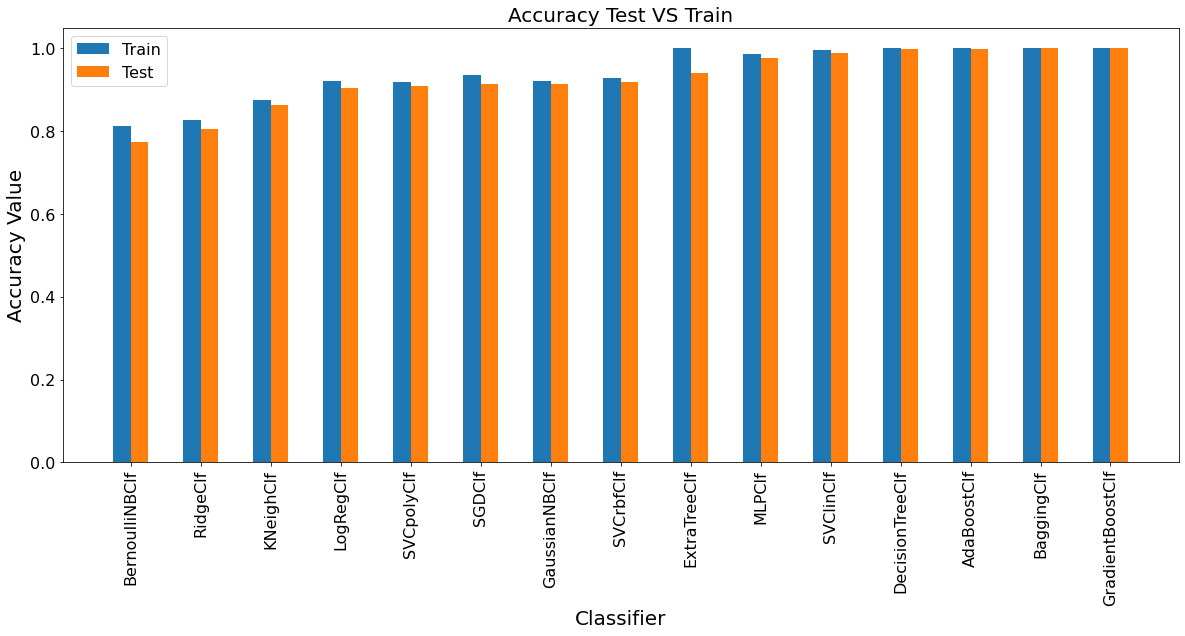

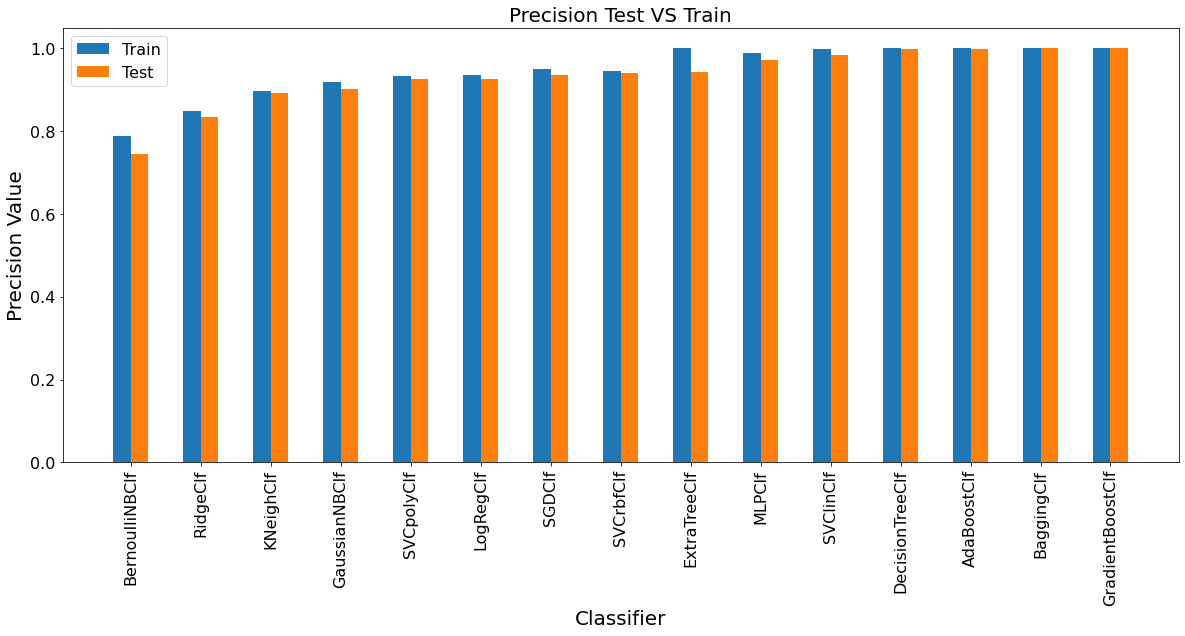

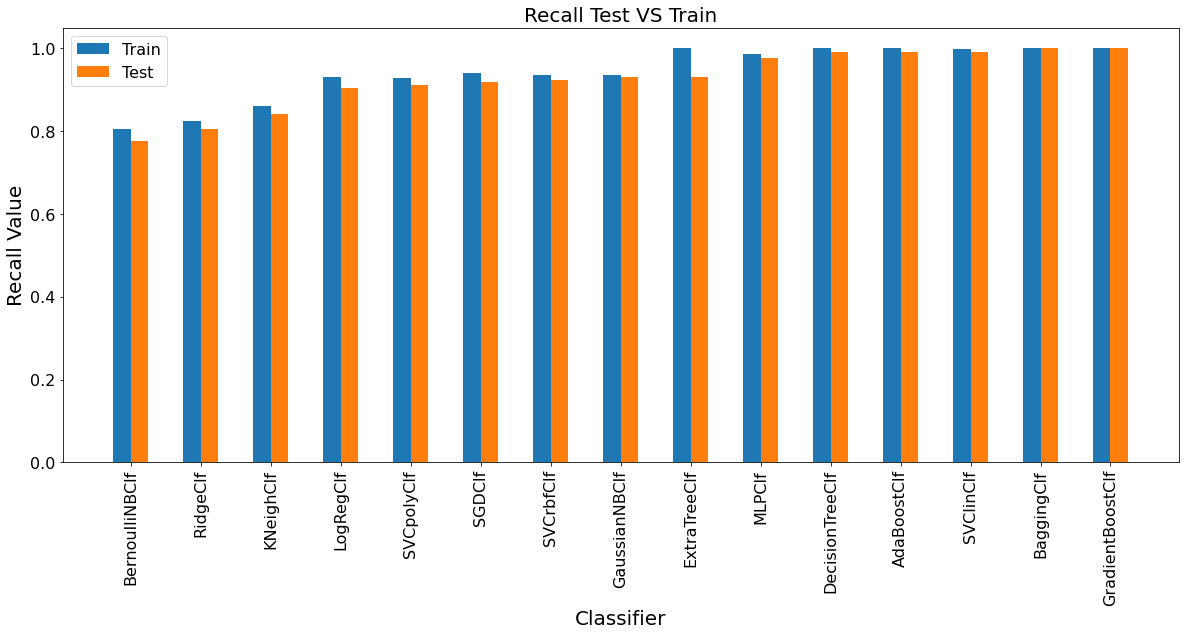

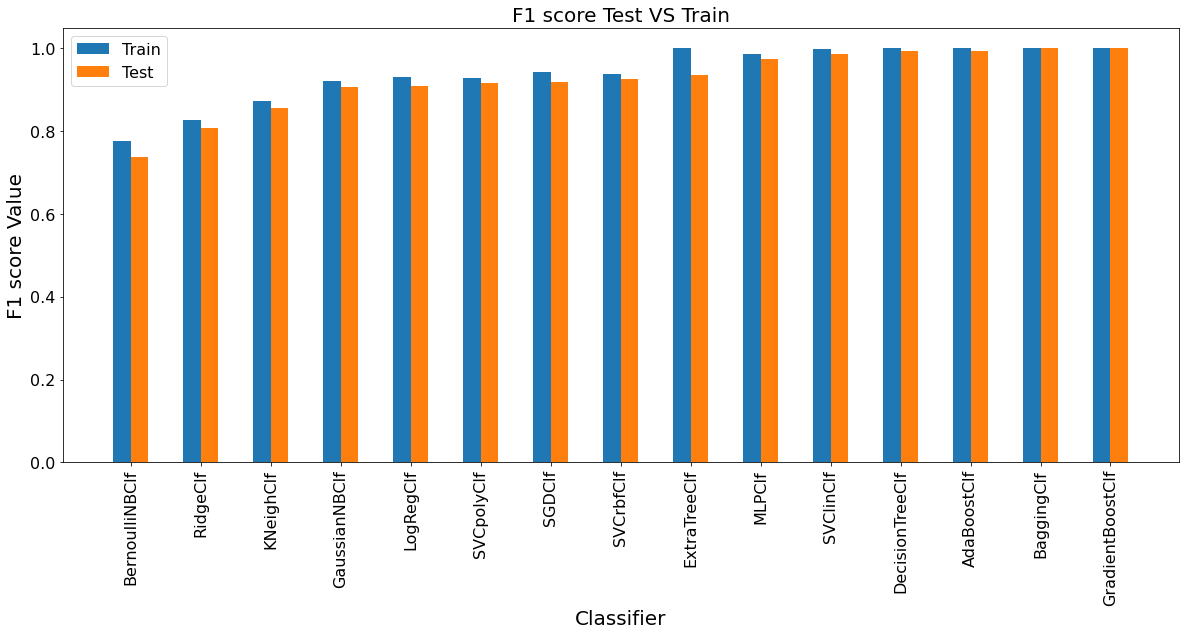

In [48]:
plot_result('3_accuracy_test', '3_accuracy_train', 'Accuracy', dt_clfs, ('Test','Train'))
plot_result('4_precision_test', '4_precision_train', 'Precision', dt_clfs, ('Test','Train'))
plot_result('5_recall_test', '5_recall_train', 'Recall', dt_clfs, ('Test','Train'))
plot_result('6_F1_test', '6_F1_train', 'F1 score', dt_clfs, ('Test','Train'))

## 5. Voting Classifier

<b><u>
Consideriamo i classificatori che hanno un F1-score inferiore all'85% e cerchiamo di migliorare il loro funzionamento fondendoli in un <font color='red'>Hard Voting Classifier</font>.
</u></b>

In [31]:
from sklearn.ensemble import VotingClassifier

In [32]:
dt_copy = dt_clfs.copy()
dt_copy = dt_copy.loc[ dt_clfs['6_F1_test'] < 0.85 ]
print(dt_copy['1_name'].values)

['BernoulliNBClf' 'RidgeClf']


In [33]:
estimators = [ (x,y) for x,y in zip(dt_copy['1_name'], dt_copy['2_model'])]
ar = []

model = VotingClassifier(estimators=estimators, voting='hard')
model.fit(X_train, y_train)
clf = compute_metrics(model, 'Voting_hard_Clf', X_train, X_test, y_train, y_test)

ar.append(clf)

In [34]:
datfra = pd.DataFrame(ar)
datfra = pd.concat([datfra, dt_clfs.loc[dt_clfs['6_F1_train'] < 0.85 ]])
dfi.export(datfra,'23-5_voting_differences.png')
datfra

,1_name,2_model,3_accuracy_train,4_precision_train,5_recall_train,6_F1_train,3_accuracy_test,4_precision_test,5_recall_test,6_F1_test
0,Voting_hard_Clf,VotingClassifier(estimators=[('BernoulliNBClf'...,0.866514,0.879644,0.832940,0.846394,0.834963,0.857552,0.803476,0.820617
8,BernoulliNBClf,BernoulliNB(),0.811774,0.788766,0.804609,0.777243,0.773839,0.743740,0.777242,0.738420
0,RidgeClf,RidgeClassifier(),0.826529,0.848400,0.823742,0.827676,0.804401,0.833000,0.804384,0.808419


## 6. Confronto VotingClassifier vs Singoli classificatori

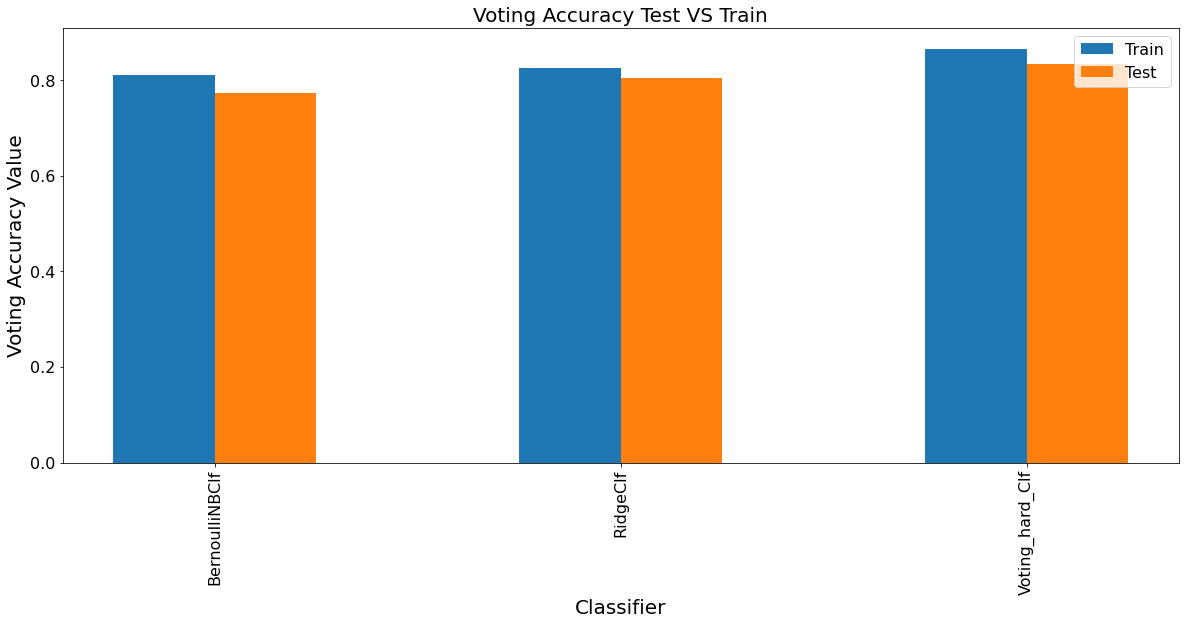

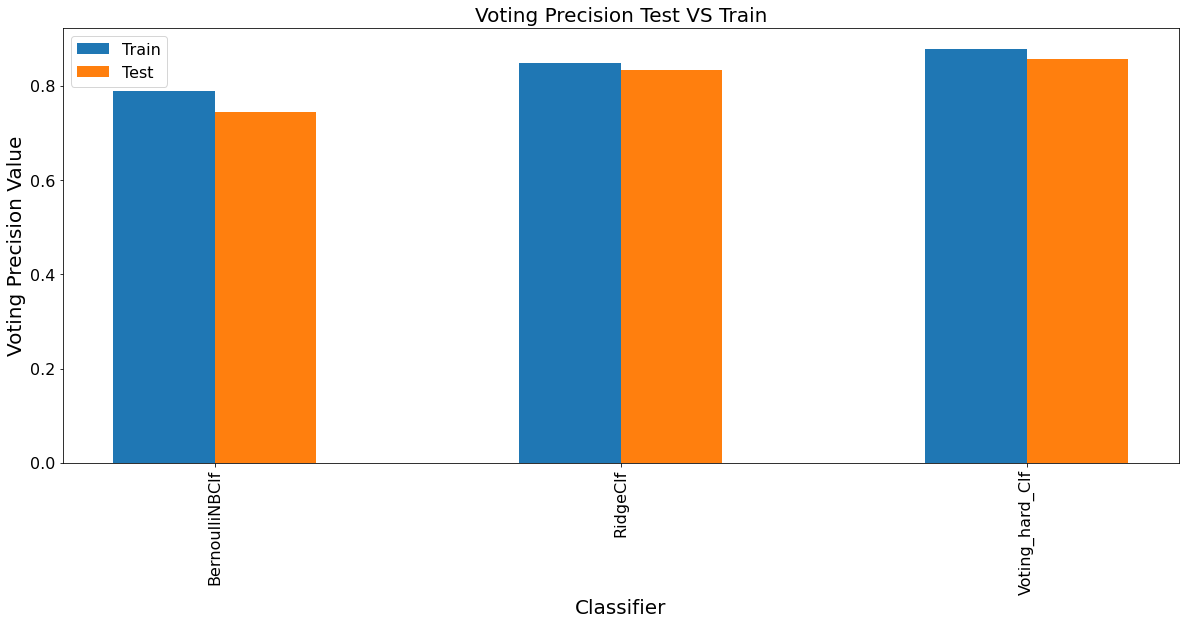

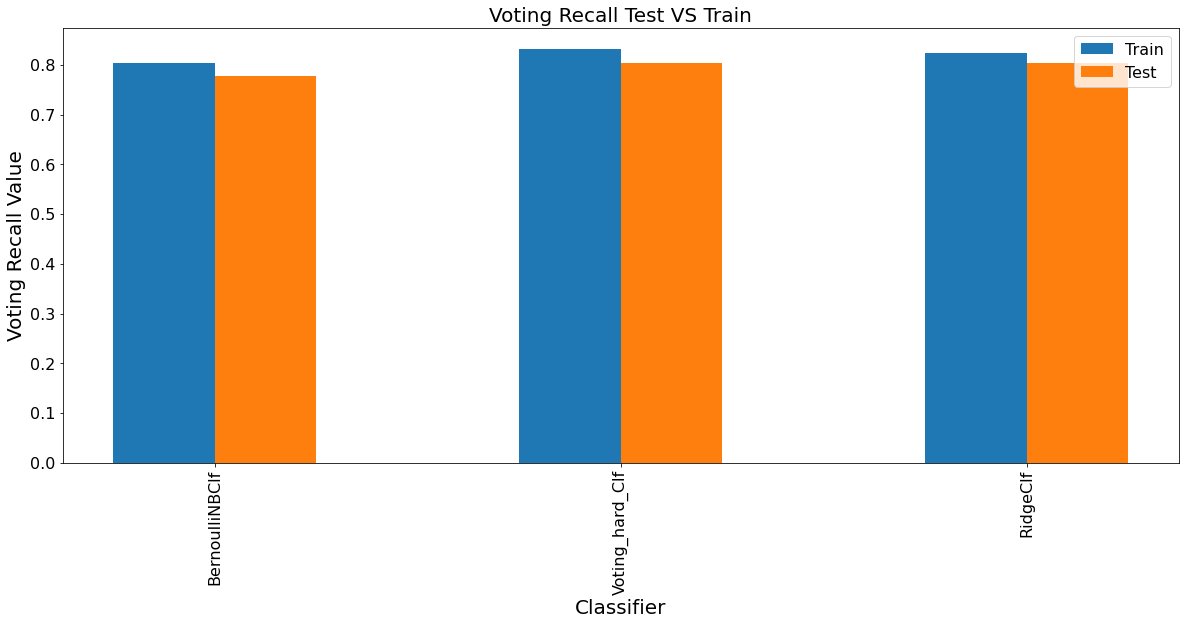

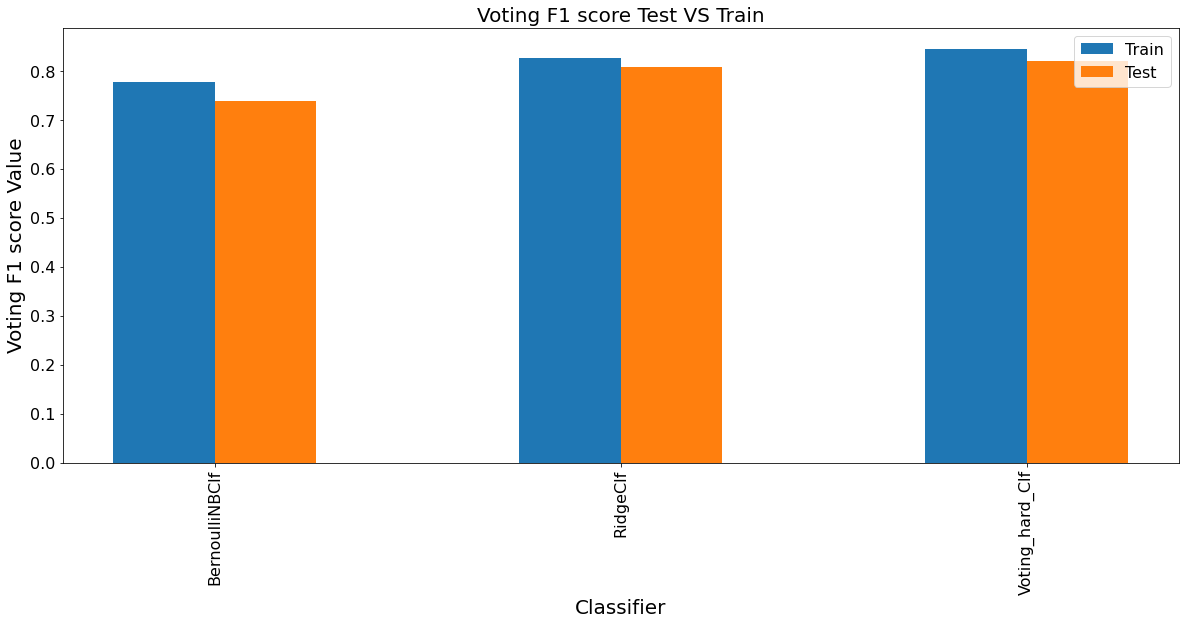

In [49]:
plot_result('3_accuracy_test', '3_accuracy_train', 'Voting Accuracy', datfra, ('Test','Train'))
plot_result('4_precision_test', '4_precision_train', 'Voting Precision', datfra, ('Test','Train'))
plot_result('5_recall_test', '5_recall_train', 'Voting Recall', datfra, ('Test','Train'))
plot_result('6_F1_test', '6_F1_train', 'Voting F1 score', datfra, ('Test','Train'))